<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/experiment_model_improvement_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective
 - Improve accuracy of base model - classification task
 - To check if the model gives better results than pre-trained models

Observations
  - Not working - the loss is not decreasing
  - use pretrained models


Models
  - NA

## Initializations
Cloning Repo, Dependencies installation, Libraries import and Config Initialization

### Cloning Repo, Installing dependencies

In [34]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 385 (delta 94), reused 157 (delta 81), pack-reused 209
Receiving objects: 100% (385/385), 26.53 MiB | 25.13 MiB/s, done.
Resolving deltas: 100% (208/208), done.


In [35]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306


In [36]:
# Installs from files
from da_cv_fer.data_config import DataConfig
# from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
# from da_cv_fer.ds_expw_crop import EXPWCROP
# from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
# from da_cv_fer.model_DANN import DANN
# from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing Configs

In [37]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset
- SFEW Dataset
- Creating Dataloader object


In [38]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Creating Dataloader

In [39]:
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Example Images

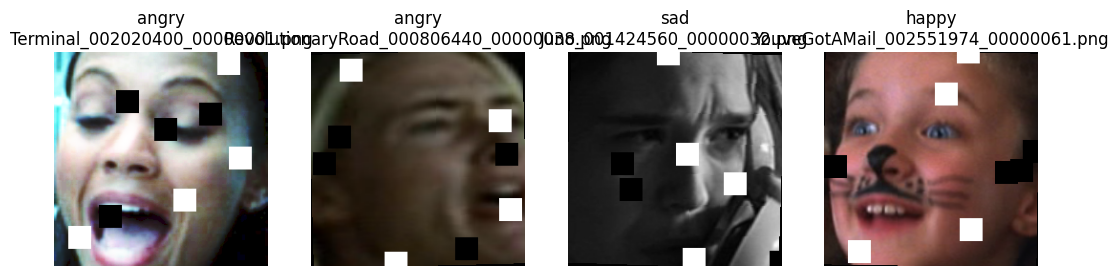

In [40]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

In [41]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']

## Model Initialization

### Simple Model_V1

In [70]:
import torch.nn as nn
# import torch
import torch.nn.functional as F

class SimpleModelv1(nn.Module):
    def __init__(self,
                 num_classes = 7,
                 dropout = 0.1):

        super(SimpleModelv1, self).__init__()
        self.num_classes = num_classes

        #---------------------Feature Extractor Network------------------------#
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # 224>224 | 3
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3, padding= 1) # 224>224 | 5
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 224>112 | 10

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 112>112 | 12
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3, padding= 1) # 112>112 | 14
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 112>56 | 28

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) # 56>56 | 30
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024, kernel_size=3, padding= 1) # 56>56 | 32
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 56>28 | 64

        self.conv7 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1) # 28>28 | 66
        self.conv8 = nn.Conv2d(in_channels=2048,out_channels=2048, kernel_size=3, padding= 1) # 28>28 | 68
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 28>14 | 136

        self.conv9 = nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=3, padding=1) # 14>14 | 138
        self.conv10 = nn.Conv2d(in_channels=512,out_channels=128, kernel_size=3, padding= 1) # 14>14 | 140
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # 14>7 | 280

        self.conv11 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3) # 7>5 | 282
        self.conv12 = nn.Conv2d(in_channels=32,out_channels=16, kernel_size=3) # 5>3 | 284
        self.conv13 = nn.Conv2d(in_channels=16,out_channels=self.num_classes, kernel_size=3) # 3>1x1xnum_classes | 286

        # #---------------------Class (Task) Classifier Network------------------------#

        # class_classifier_layers = [nn.ReLU(),
        #                            nn.Dropout(p=dropout),
        #                            nn.Linear(1280,100),
        #                            nn.ReLU(),
        #                            nn.Dropout(p=dropout)]

        # class_classifier_layers.extend([nn.ReLU(),
        #                                 nn.Dropout(p=dropout),
        #                                 nn.Linear(100,num_classes)])

        # self.class_classifier = nn.Sequential(*class_classifier_layers)
        # print (self.class_classifier)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        # print("after first max pool, shape :", x.shape)
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        # print("after second max pool, shape :", x.shape)
        x = self.pool3(F.relu(self.conv6(F.relu(self.conv5(x)))))
        # print("after third max pool, shape :", x.shape)
        x = self.pool4(F.relu(self.conv8(F.relu(self.conv7(x)))))
        # print("after fourth max pool, shape :", x.shape)
        x = self.pool5(F.relu(self.conv10(F.relu(self.conv9(x)))))
        # print("after fifth max pool, shape :", x.shape)
        x = self.conv13(F.relu(self.conv12(F.relu(self.conv11(x)))))
        # print("after convolution shape :", x.shape)

        x = x.view(-1, self.num_classes)
        # print("after reshaping - view shape :", x.shape)
        return x
        # return F.log_softmax(x, dim=1)

In [71]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [72]:
model = SimpleModelv1().to(device=device)

#### Model params

In [73]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 64, 224, 224]          18,496
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5        [-1, 256, 112, 112]         295,168
         MaxPool2d-6          [-1, 256, 56, 56]               0
            Conv2d-7          [-1, 512, 56, 56]       1,180,160
            Conv2d-8         [-1, 1024, 56, 56]       4,719,616
         MaxPool2d-9         [-1, 1024, 28, 28]               0
           Conv2d-10         [-1, 2048, 28, 28]      18,876,416
           Conv2d-11         [-1, 2048, 28, 28]      37,750,784
        MaxPool2d-12         [-1, 2048, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       9,437,696
           Conv2d-14          [-1, 128,

#### Running Model for single Run

In [74]:
for usage, dict_data_loader in data_loader.items(): ## {'source' : sfew_loader,'target' : expw_loader}
    print('-'*80)
    print(usage)
    for k, v in dict_data_loader.items(): # {'name': 'sfew','train':sfew_train_loader,'val':sfew_val_loader}
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ", labels: ",labels.shape)
        print("Input labels:\n", labels)
        print("Input labels - index", labels.argmax(dim=1))

        x_labels = model(images) # forward pass
        print("Output:\n", "labels shape: ", x_labels.shape)
        print("Output labels:\n", x_labels)
        print("Output labels - index", x_labels.argmax(dim=1))


--------------------------------------------------------------------------------
source
--------name of dataset : sfew--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Input labels:
 tensor([[0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')
Input labels - index tensor([5, 3, 2, 5, 5, 4, 0, 4, 1, 4, 2, 5, 3, 3, 3, 5], device='cuda:0')
Output:
 labels shape:

## Training and Testing

In [75]:
from tqdm import tqdm
import torch.nn.functional as F

### Train Function

In [76]:
import torch.nn as nn
def train(model, device, train_loader,
          optimizer, epoch,
          # loss_fn = F.cross_entropy
          # loss_fn = F.nll_loss
          # loss_fn = F.binary_cross_entropy_with_logits
          loss_fn = nn.CrossEntropyLoss()

          ):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target,img_name) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = loss_fn(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    # correct += pred.eq(target.view_as(pred)).sum().item()
    correct += (pred.argmax(dim=1).eq(target.argmax(dim=1))).sum().item()

    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

### Test Function

In [77]:
def test(model, device, test_loader,
        #  loss_fn = F.cross_entropy
        #  loss_fn = F.nll_loss
        #  loss_fn = F.binary_cross_entropy_with_logits
        loss_fn = nn.CrossEntropyLoss()
         ):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target, img_name in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += (pred.argmax(dim=1).eq(target.argmax(dim=1))).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('--Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Execution

In [78]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rate = 0.001
model = SimpleModelv1().to(device)
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader=data_loader['source']['train'], optimizer=optimizer, epoch=epoch)
    test(model, device, test_loader = data_loader['source']['val'])

EPOCH: 0


Loss=2.029139995574951 Batch_id=57 Accuracy=18.95: 100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


--Test set: Average loss: 0.1250, Accuracy: 75/419 (17.90%)

EPOCH: 1


Loss=2.0697152614593506 Batch_id=57 Accuracy=18.95: 100%|██████████| 58/58 [00:35<00:00,  1.61it/s]


--Test set: Average loss: 0.1244, Accuracy: 75/419 (17.90%)

EPOCH: 2


Loss=1.921555519104004 Batch_id=10 Accuracy=17.05:  19%|█▉        | 11/58 [00:08<00:34,  1.37it/s]


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t_items.item() for t_items in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")